In [1]:
import pandas as pd
import numpy as np
import os 
import shutil
from tqdm import tqdm


import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
from torchvision.transforms import *

import albumentations as A
import albumentations.pytorch

from efficientnet_pytorch import EfficientNet
    
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# from catalyst.data import DynamicBalanceClassSampler


import time
import cv2
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline  
%config InlineBackend.figure_format='retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# hyperparameter 
img_path = 'input/data/train/images'
batch_size = 128
num_workers = 2
learning_rate = 0.001
epochs = 10
img_size = 256

In [3]:
df = pd.read_csv('preprocessing_data.csv')
df.drop(columns=['Unnamed: 0'], inplace = True)
df.head()

path      id  mask  gender  \
0  input/data/train/images/000001_female_Asian_45...  000001     0       1   
1  input/data/train/images/000001_female_Asian_45...  000001     2       1   
2  input/data/train/images/000001_female_Asian_45...  000001     0       1   
3  input/data/train/images/000001_female_Asian_45...  000001     0       1   
4  input/data/train/images/000001_female_Asian_45...  000001     1       1   

   age  label  
0    1      4  
1    1     16  
2    1      4  
3    1      4  
4    1     10

In [4]:
train_x , val_x , train_y , val_y = train_test_split(df , df['label'] , test_size=0.3 , shuffle = False)

In [5]:
# torchvision tramsforms 사용 
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path , df ,transform = None):
        
        self.path = path
        self.df = df
        self.transform = transform
        
    def __getitem__(self,idx):
        image = Image.open(self.df['path'].iloc[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.df['label'].iloc[idx]
        return image, label
    
    def __len__(self):
        return len(self.df)

In [37]:
train_x , val_x , train_y , val_y = train_test_split(df , df['label'] , test_size=0.3 ,shuffle = True)

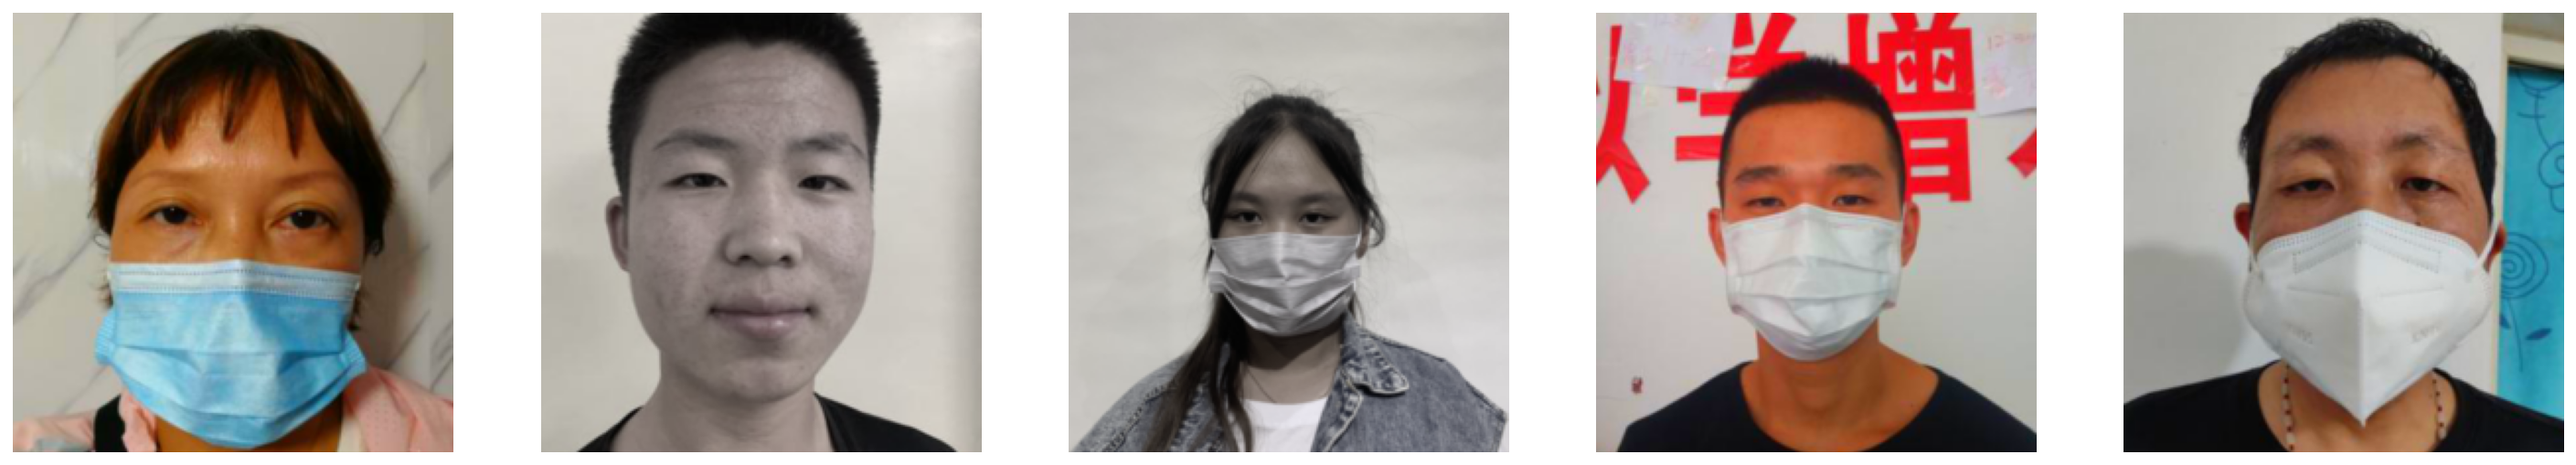

In [7]:
mean=[0.548, 0.504, 0.479]
std=[0.237, 0.247, 0.246]
transform = transforms.Compose([
            Resize(256 , Image.BILINEAR),
            CenterCrop(224),
            ColorJitter(saturation = 1),
            ToTensor()
            # Normalize(mean=mean, std=std),
        ])

train_dataset = CustomDataset(img_path , train_x , transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1 , shuffle = True , num_workers = num_workers)

num_samples = 5
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
    ax[i].imshow(transforms.ToPILImage()(train_dataset[i][0]))
    ax[i].axis('off')

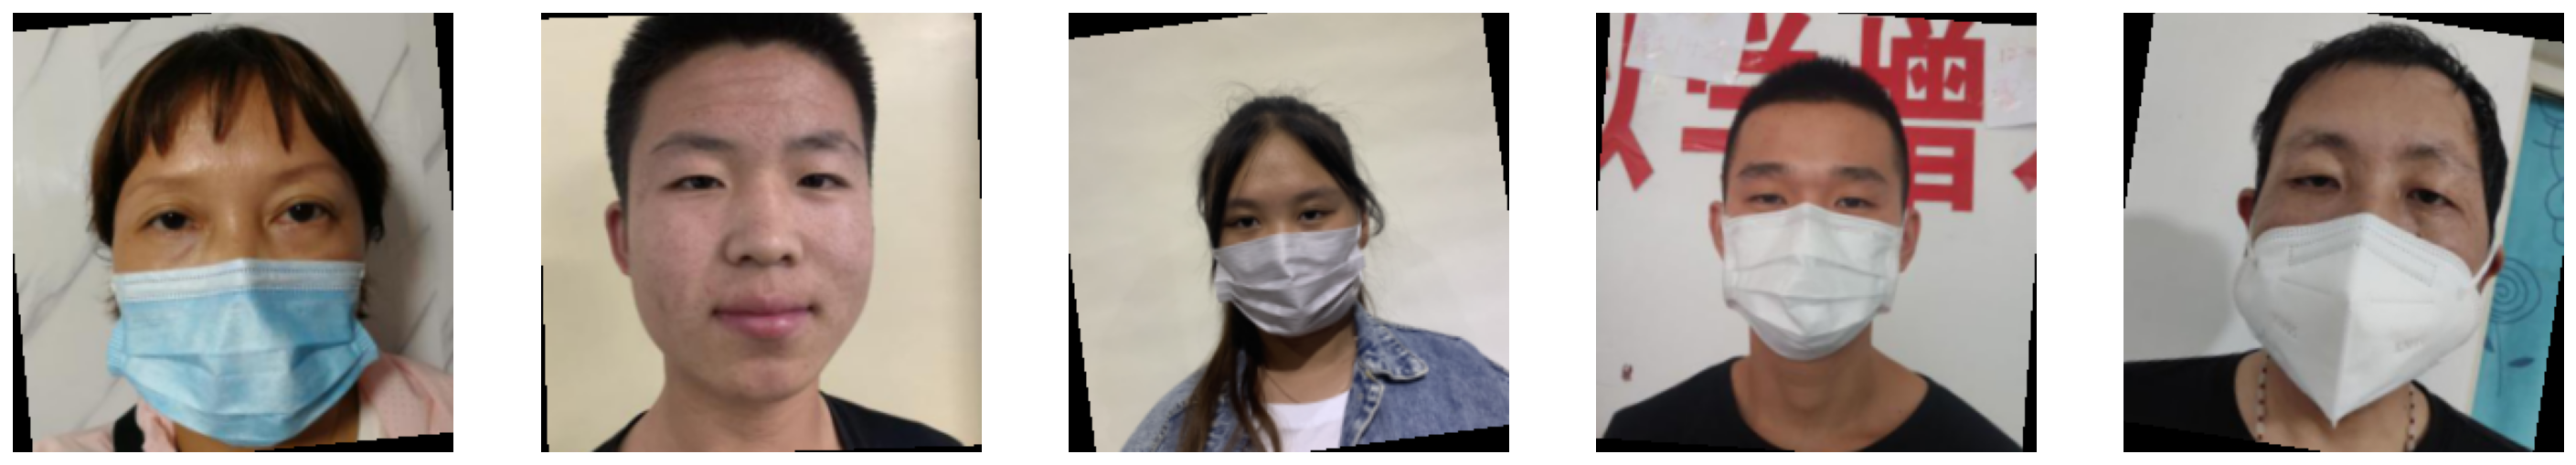

In [8]:
mean=[0.548, 0.504, 0.479]
std=[0.237, 0.247, 0.246]
transform = transforms.Compose([
            Resize(256 , Image.BILINEAR),
            CenterCrop(224),
            RandomRotation(10 ,Image.BILINEAR ),
            ToTensor()
            # Normalize(mean=mean, std=std),
        ])

train_dataset = CustomDataset(img_path , train_x , transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1 , shuffle = True , num_workers = num_workers)

num_samples = 5
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
    ax[i].imshow(transforms.ToPILImage()(train_dataset[i][0]))
    ax[i].axis('off')

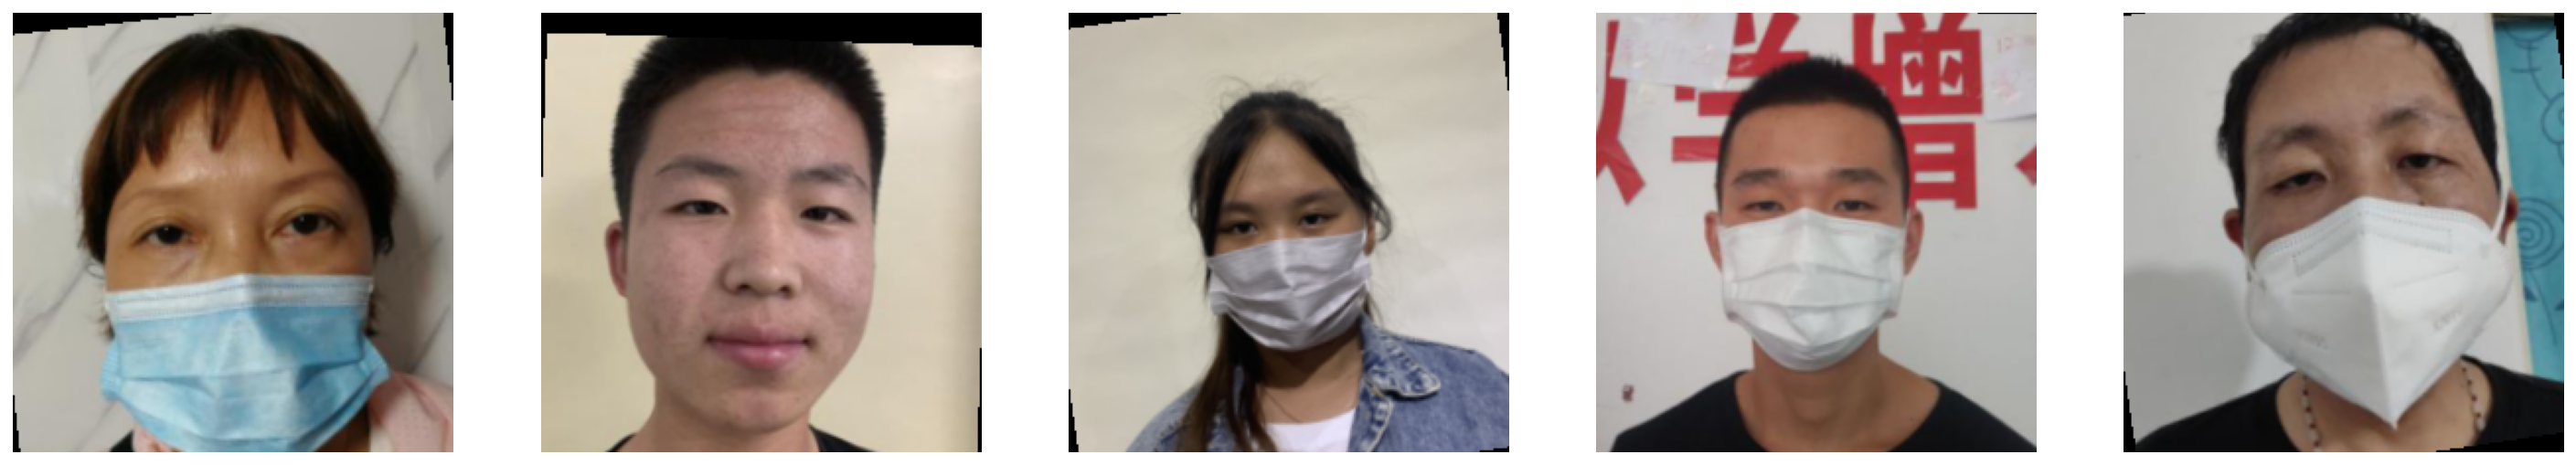

In [9]:
mean=[0.548, 0.504, 0.479]
std=[0.237, 0.247, 0.246]
transform = transforms.Compose([
            Resize(256 , Image.BILINEAR),
            CenterCrop(224),
            RandomAffine(10 , (0,0.1) , (1,1.1) , (0,0.1) , Image.BILINEAR ),
            ToTensor()
#            Normalize(mean=mean, std=std),
        ])

train_dataset = CustomDataset(img_path , train_x , transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1 , shuffle = True , num_workers = num_workers)

num_samples = 5
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
    ax[i].imshow(transforms.ToPILImage()(train_dataset[i][0]))
    ax[i].axis('off')

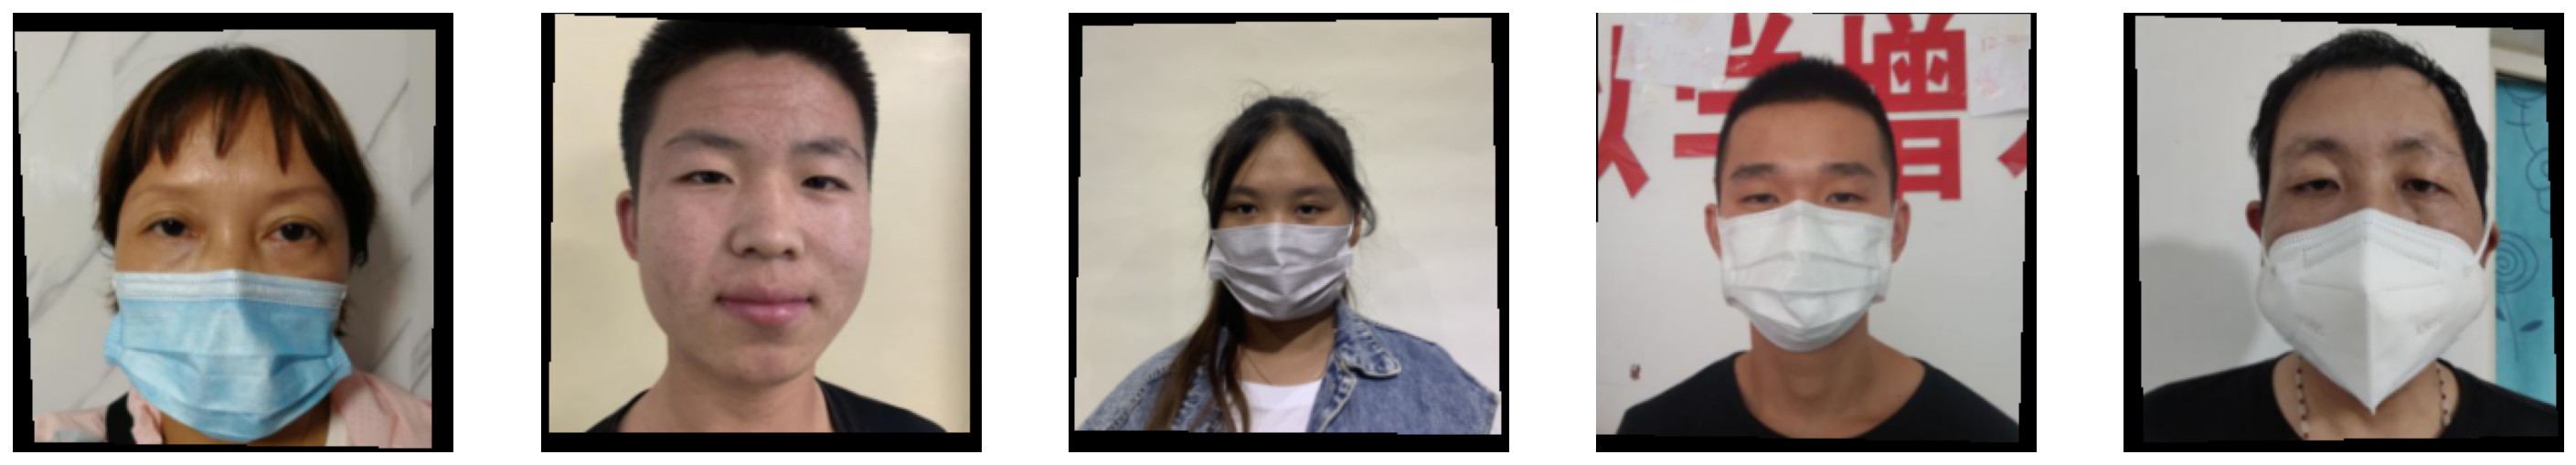

In [10]:

mean=[0.548, 0.504, 0.479]
std=[0.237, 0.247, 0.246]
transform = transforms.Compose([
            Resize(256 , Image.BILINEAR),
            CenterCrop(224),
            RandomPerspective(distortion_scale=0.1, p=1, interpolation= Image.BILINEAR),
            ToTensor()
            #Normalize(mean=mean, std=std),
        ])

train_dataset = CustomDataset(img_path , train_x , transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1 , shuffle = True , num_workers = num_workers)

num_samples = 5
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
    ax[i].imshow(transforms.ToPILImage()(train_dataset[i][0]))
    ax[i].axis('off')

KeyError: 0

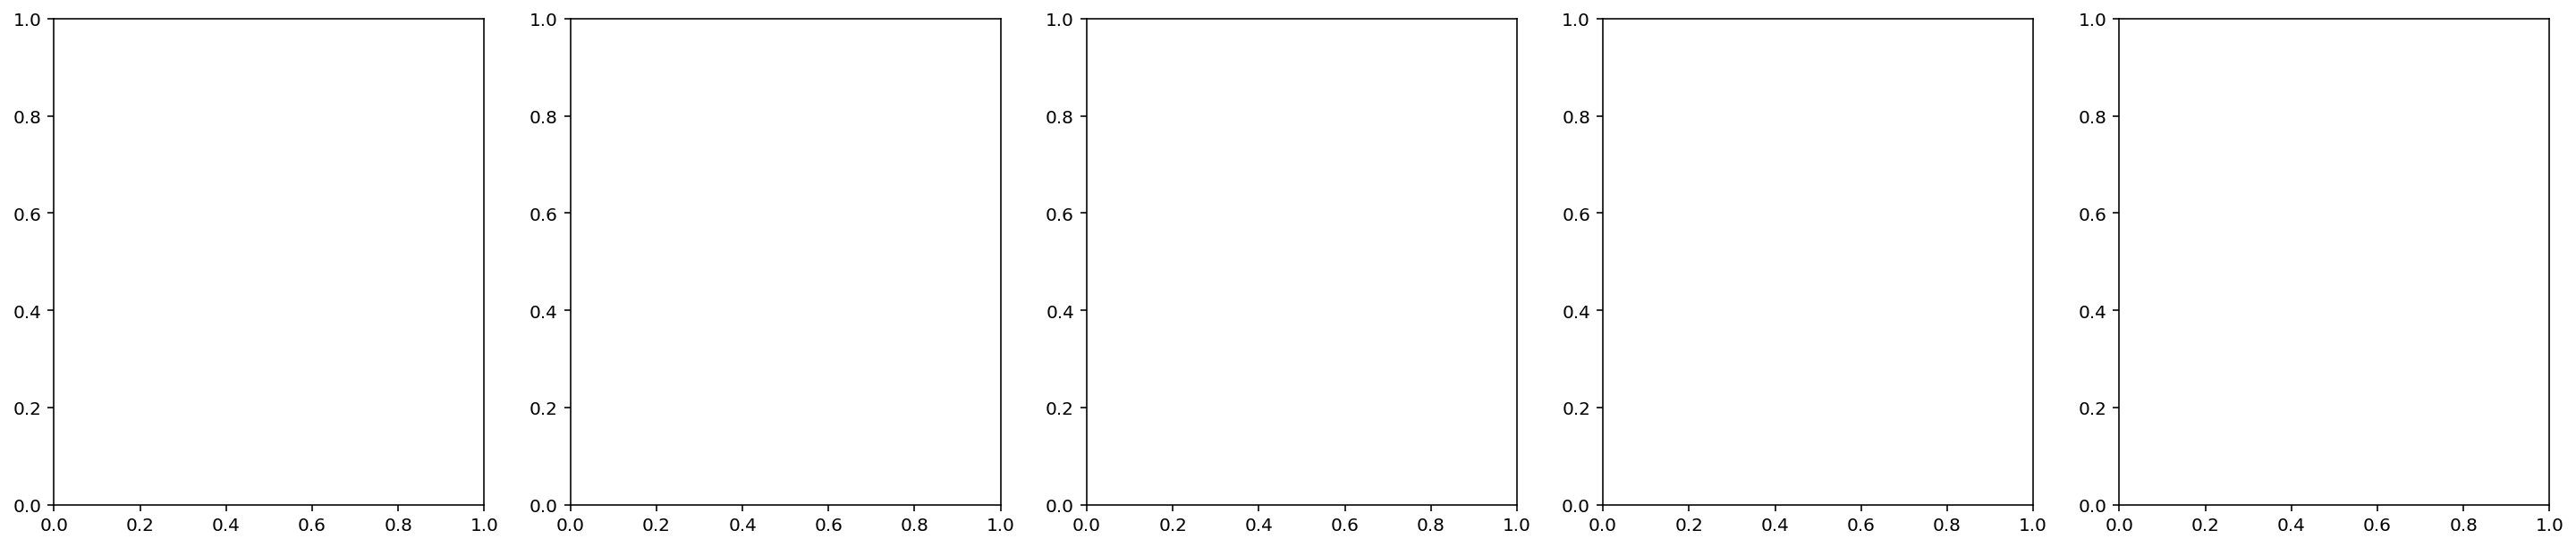

In [38]:
mean=[0.548, 0.504, 0.479]
std=[0.237, 0.247, 0.246]
transform = transforms.Compose([
            CenterCrop(224),
            ToTensor()
            #Normalize(mean=mean, std=std),
        ])

train_dataset = CustomDataset(img_path , train_x , transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1 , shuffle = True , num_workers = num_workers)
num_samples = 5
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
    ax[i].imshow(transforms.ToPILImage()(train_x[i][0]))
    ax[i].axis('off')

TypeError: __call__() got an unexpected keyword argument 'image'

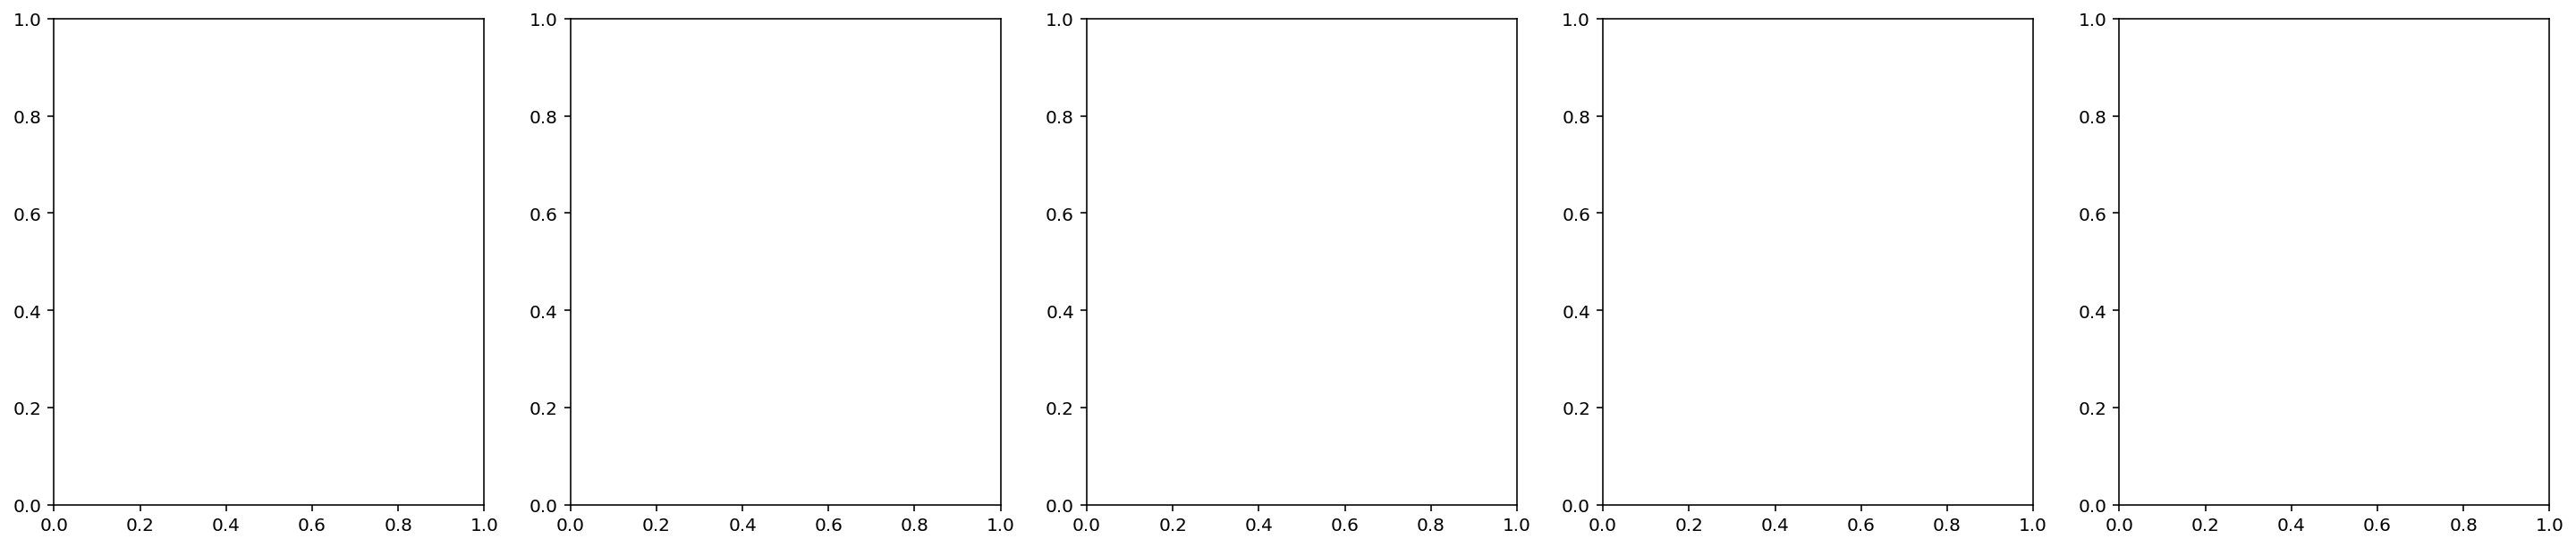

In [36]:
# class RandomCropAugmentation:
#     def __init__(self, resize, mean, std, **args):
#         self.transform = transforms.Compose([
#             CenterCrop(256),
#             RandomCrop(resize),
#             ToTensor(),
#             Normalize(mean=mean, std=std)
#         ])

#     def __call__(self, image):
#         return self.transform(image)
    
transform = transforms.Compose([
            CenterCrop(256),
            RandomCrop(224),
            ToTensor()
            #Normalize(mean=mean, std=std),
        ])

train_dataset = CustomDataset(img_path , train_x , transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1 , shuffle = True , num_workers = num_workers)
num_samples = 5
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
    ax[i].imshow(transforms.ToPILImage()(train_dataset[i][0]))
    ax[i].axis('off')

--------------------------------------------------------------------------------
#### 1번 실험 transform VS albumentation : 누가 더 빠를까?
dataset을 돌리기만 하면 100번 기준 0.25초 정도 albu가 더 빠르다! </br>
근데 왜 train속도는 똑같을까?

-------------------------------------------------------------------------------

In [13]:
# # torchvision tramsforms 사용 
# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self, path , df ,transform = None):
        
#         self.path = path
#         self.df = df
#         self.transform = transform
        
#     def __getitem__(self,idx):
#         image = Image.open(self.df['path'].iloc[idx]).convert("RGB")
#         if self.transform:
#             image = self.transform(image)
#         label = self.df['label'].iloc[idx]
#         return image, label
    
#     def __len__(self):
#         return len(self.df)

In [14]:
# # torchvision tramsforms 사용 
# train_transforms = transforms.Compose([
#                                     transforms.Resize((img_size, img_size)),
#                                     transforms.ToTensor(),
#                                     transforms.Normalize([0.485, 0.456, 0.406],
#                                                          [0.229, 0.224, 0.225])])

# val_transforms = transforms.Compose([
#                                     transforms.Resize((img_size, img_size)),
#                                     transforms.ToTensor(),
#                                     transforms.Normalize([0.485, 0.456, 0.406],
#                                                          [0.229, 0.224, 0.225])])

In [15]:
# albumentation 사용
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path , df ,transform = None):
        
        self.path = path
        self.df = df
        self.transform = transform
        
    def __getitem__(self,idx):
        image = cv2.imread(self.df['path'].iloc[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image) 
            image = augmented['image']
        label = self.df['label'].iloc[idx]
        return image, label

    def __len__(self):
        return len(self.df)

In [16]:
# albumentation 사용 
# train_transforms = A.Compose([
#     A.Resize(256,256),
#     A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
#     A.pytorch.transforms.ToTensor()
# ])

# val_transforms = A.Compose([
#     A.Resize(256,256),
#     A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
#     A.pytorch.transforms.ToTensor()
# ])

# # ---------------------------------------------------------------------------------------------------------------------------------- #
# train_x , val_x , train_y , val_y = train_test_split(df , df['label'] , test_size=0.3 )

# train_dataset = CustomDataset(img_path , train_x , train_transforms)
# val_dataset = CustomDataset(img_path , val_x , val_transforms)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size , shuffle = True , num_workers = num_workers)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size , shuffle = True , num_workers = num_workers)

In [17]:
# # torch transform 사용
# start = time.time()
# for i , (img , tgt) in enumerate(train_dataset):
#     if i == 100 :
#         end = time.time()
#         print(f'소요시간 : {end - start}')
#         break

---------------------------------------------------------------------------
#### 2번 실험 : 어떤 augmentation 조합이 성능이 좋을까?
- base : resize만 256,256 으로 한 경우 
- rotate : 모두 다 정면만 보고 있는데 굳이 해야 될까? 갸웃 수준으로 +-10만 해보자!
---------------------------------------------------------------------------

##### 1. Rotate
- 10도 안팎으로 돌려보기 
- 10 epoch 기준 : 72.35%  0.62%

In [18]:
# # rotate_albumentation 사용 
# rotate_train_transforms = A.Compose([
#     A.Resize(256,256),
#     A.Rotate(limit = 10 , border_mode =  1),                     # 'cv2.BORDER_REPLICATE' = 1
#     A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
#     A.pytorch.transforms.ToTensor()
# ])

# rotate_val_transforms = A.Compose([
#     A.Resize(256,256),
#     A.Rotate(limit = 10 , border_mode = 1),
#     A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
#     A.pytorch.transforms.ToTensor()
# ])

# train_x , val_x , train_y , val_y = train_test_split(df , df['label'] , test_size=0.3 )

# train_dataset = CustomDataset(img_path , train_x , rotate_train_transforms)
# val_dataset = CustomDataset(img_path , val_x , rotate_val_transforms)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size , shuffle = True , num_workers = num_workers)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size , shuffle = True , num_workers = num_workers)

In [19]:
# 실험 대체용 코드 
# class AlbumentationsDataset(Dataset):
#     """__init__ and __len__ functions are the same as in TorchvisionDataset"""
#     def __init__(self, file_paths, labels, transform=None):
#         self.file_paths = file_paths
#         self.labels = labels
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.file_paths)

#     def __getitem__(self, idx):
#         label = self.labels[idx]
#         file_path = self.file_paths[idx]
        
#         # Read an image with OpenCV
#         image = cv2.imread(file_path)
        
#         # By default OpenCV uses BGR color space for color images,
#         # so we need to convert the image to RGB color space.
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         start_t = time.time()
#         if self.transform:
#             augmented = self.transform(image=image) 
#             image = augmented['image']
#         total_time = (time.time() - start_t)
#         return image, label, total_time
    
# albumentations_dataset = AlbumentationsDataset(
#     file_paths=["input/data/eval/mask.jpg"],
#     labels=[1],
#     transform=rotate_train_transforms,
# )

# num_samples = 5
# fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
# for i in range(num_samples):
#     ax[i].imshow(transforms.ToPILImage()(albumentations_dataset[0][0]))
#     ax[i].axis('off')

In [20]:
# num_samples = 5
# fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
# for i in range(num_samples):
#     ax[i].imshow(transforms.ToPILImage()(train_dataset[0][0] ))
#     ax[i].axis('off')

------------------------------------
##### 2. RandomCrop
- sclae & ratio에 따라 비교
- 10 epoch 기준 :
    - scale & ratio default :  78.83% 0.74%
    - scale=(0.4, 1.0) & ratio = (0.75 , 1)  : 

In [21]:
# # randomcrop_albumentation 사용 
# randomcrop_train_transforms = A.Compose([
#     A.Resize(256,256),
#     A.RandomResizedCrop(256,256, scale=(0.4, 1.0) , ratio = (0.75 , 1)) ,                     # 'cv2.BORDER_REPLICATE' = 1
#     A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
#     A.pytorch.transforms.ToTensor()
# ])

# randomcrop_val_transforms = A.Compose([
#     A.Resize(256,256),
#     A.RandomResizedCrop(256,256, scale=(0.4, 1.0) , ratio = (0.75 , 1)),
#     A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
#     A.pytorch.transforms.ToTensor()
# ])

# train_x , val_x , train_y , val_y = train_test_split(df , df['label'] , test_size=0.3 )

# train_dataset = CustomDataset(img_path , train_x , randomcrop_train_transforms)
# val_dataset = CustomDataset(img_path , val_x , randomcrop_val_transforms)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size , shuffle = True , num_workers = num_workers)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size , shuffle = True , num_workers = num_workers)

In [22]:
# # 실험 대체용 코드 
# class AlbumentationsDataset(Dataset):
#     """__init__ and __len__ functions are the same as in TorchvisionDataset"""
#     def __init__(self, file_paths, labels, transform=None):
#         self.file_paths = file_paths
#         self.labels = labels
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.file_paths)

#     def __getitem__(self, idx):
#         label = self.labels[idx]
#         file_path = self.file_paths[idx]
        
#         # Read an image with OpenCV
#         image = cv2.imread(file_path)
        
#         # By default OpenCV uses BGR color space for color images,
#         # so we need to convert the image to RGB color space.
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         start_t = time.time()
#         if self.transform:
#             augmented = self.transform(image=image) 
#             image = augmented['image']
#         total_time = (time.time() - start_t)
#         return image, label, total_time
    
# albumentations_dataset = AlbumentationsDataset(
#     file_paths=["input/data/eval/mask.jpg"],
#     labels=[1],
#     transform=randomcrop_train_transforms,
# )

# num_samples = 5
# fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
# for i in range(num_samples):
#     ax[i].imshow(transforms.ToPILImage()(albumentations_dataset[0][0]))
#     ax[i].axis('off')

In [23]:
# num_samples = 7
# fig, ax = plt.subplots(1, num_samples, figsize=(25, 7))
# for i in range(num_samples):
#     ax[i].imshow(transforms.ToPILImage()(train_dataset[10][0] ))
#     ax[i].axis('off')

--------------------------------------------------------------------------
##### 3.HorizontalFlip
- vertical은 그럴 일이 없으므로 적용 X
- 10 epoch 기준 : 

In [24]:
# # HorizontalFlip_albumentation 사용 
# Flip_train_transforms = A.Compose([
#     A.Resize(256,256),
#     A.HorizontalFlip(p=0.5),                  
#     A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
#     A.pytorch.transforms.ToTensor()
# ])

# Flip_val_transforms = A.Compose([
#     A.Resize(256,256),
#     A.HorizontalFlip(p=0.5),
#     A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
#     A.pytorch.transforms.ToTensor()
# ])

# train_x , val_x , train_y , val_y = train_test_split(df , df['label'] , test_size=0.3 )

# train_dataset = CustomDataset(img_path , train_x , Flip_train_transforms)
# val_dataset = CustomDataset(img_path , val_x , Flip_val_transforms)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size , shuffle = True , num_workers = num_workers)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size , shuffle = True , num_workers = num_workers)

In [25]:
# # 실험 대체용 코드 
# class AlbumentationsDataset(Dataset):
#     """__init__ and __len__ functions are the same as in TorchvisionDataset"""
#     def __init__(self, file_paths, labels, transform=None):
#         self.file_paths = file_paths
#         self.labels = labels
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.file_paths)

#     def __getitem__(self, idx):
#         label = self.labels[idx]
#         file_path = self.file_paths[idx]
        
#         # Read an image with OpenCV
#         image = cv2.imread(file_path)
        
#         # By default OpenCV uses BGR color space for color images,
#         # so we need to convert the image to RGB color space.
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         start_t = time.time()
#         if self.transform:
#             augmented = self.transform(image=image) 
#             image = augmented['image']
#         total_time = (time.time() - start_t)
#         return image, label, total_time
    
# albumentations_dataset = AlbumentationsDataset(
#     file_paths=["input/data/eval/mask.jpg"],
#     labels=[1],
#     transform=Flip_train_transforms,
# )

# num_samples = 5
# fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
# for i in range(num_samples):
#     ax[i].imshow(transforms.ToPILImage()(albumentations_dataset[0][0]))
#     ax[i].axis('off')

In [26]:
# num_samples = 7
# fig, ax = plt.subplots(1, num_samples, figsize=(25, 7))
# for i in range(num_samples):
#     ax[i].imshow(transforms.ToPILImage()(train_dataset[10][0] ))
#     ax[i].axis('off')

--------------------------------------------------------------------------
##### 4.JpegCompression => Noise 추가 
- 0 ~ 50
- 10 epoch 기준 : 

In [27]:
# JpegCompression_albumentation 사용 
Jpeg_train_transforms = A.Compose([
    A.Resize(256,256),
    A.JpegCompression(quality_lower=0, quality_upper=50),                  
    A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    A.pytorch.transforms.ToTensor()
])

Jpeg_val_transforms = A.Compose([
    A.Resize(256,256),
    A.JpegCompression(quality_lower=0, quality_upper=50),    
    A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    A.pytorch.transforms.ToTensor()
])

train_x , val_x , train_y , val_y = train_test_split(df , df['label'] , test_size=0.3 )

train_dataset = CustomDataset(img_path , train_x , Jpeg_train_transforms)
val_dataset = CustomDataset(img_path , val_x , Jpeg_val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size , shuffle = True , num_workers = num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size , shuffle = True , num_workers = num_workers)

In [28]:
# # 실험 대체용 코드 
# class AlbumentationsDataset(Dataset):
#     """__init__ and __len__ functions are the same as in TorchvisionDataset"""
#     def __init__(self, file_paths, labels, transform=None):
#         self.file_paths = file_paths
#         self.labels = labels
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.file_paths)

#     def __getitem__(self, idx):
#         label = self.labels[idx]
#         file_path = self.file_paths[idx]
        
#         # Read an image with OpenCV
#         image = cv2.imread(file_path)
        
#         # By default OpenCV uses BGR color space for color images,
#         # so we need to convert the image to RGB color space.
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         start_t = time.time()
#         if self.transform:
#             augmented = self.transform(image=image) 
#             image = augmented['image']
#         total_time = (time.time() - start_t)
#         return image, label, total_time
    
# albumentations_dataset = AlbumentationsDataset(
#     file_paths=["input/data/eval/mask.jpg"],
#     labels=[1],
#     transform=Jpeg_train_transforms,
# )

# num_samples = 5
# fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
# for i in range(num_samples):
#     ax[i].imshow(transforms.ToPILImage()(albumentations_dataset[0][0]))
#     ax[i].axis('off')

In [29]:
# num_samples = 7
# fig, ax = plt.subplots(1, num_samples, figsize=(25, 7))
# for i in range(num_samples):
#     ax[i].imshow(transforms.ToPILImage()(train_dataset[10][0] ))
#     ax[i].axis('off')

# Model & Train

In [30]:
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        self.model._fc = nn.Linear(1280,18)
        
    def forward(self,x):
        x = self.model(x)
        return x

In [31]:
def train(epochs , train_loader, val_loader , model , criterion , optimizer , lr_scheduler = None):
    for epoch in range(epochs):
        ##################################### train ################################
        model.train()
        
        loss_train_sum = 0
        acc_train_sum = 0
        
        for i , (img , target) in enumerate(tqdm(train_loader)):
            img = img.to(device)
            target = target.to(device)
            
            y_pred = model.forward(img)
            loss = criterion(y_pred, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train_sum += loss
            acc_train_sum += (y_pred.argmax(1) == target).sum().item()/ batch_size

        loss_train_avg = loss_train_sum / len(train_loader)
        acc_train_avg = acc_train_sum / len(train_loader)
        print(f" epoch:[{epoch+1}/{epochs}] cost:[{loss_train_avg:.3f}] acc : [{acc_train_avg : .3f}]")
        
        ##################################### eval ################################
        model.eval()
        
        loss_val_sum = 0
        acc_val_sum = 0
        
        for i , (img , target) in enumerate(tqdm(val_loader)):
            img = img.to(device)
            target = target.to(device)
            
            with torch.no_grad():
                y_pred = model.forward(img)
                loss = criterion(y_pred, target)
            
            loss_val_sum += loss
            acc_val_sum += (y_pred.argmax(1) == target).sum().item()/ batch_size
        
        loss_val_avg = loss_val_sum / len(val_loader)
        acc_val_avg = acc_val_sum / len(val_loader)
        print(f" epoch:[{epoch+1}/{epochs}] cost:[{loss_val_avg:.3f}] acc : [{acc_val_avg : .3f}]")
        
        if lr_scheduler:
            lr_scheduler.step()
        

In [32]:
Model = BaseModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model.parameters() , lr = learning_rate)
#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

Loaded pretrained weights for efficientnet-b0


In [33]:
train(epochs , train_loader , val_loader , Model, criterion , optimizer)

  0%|          | 0/104 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 23.88 GiB total capacity; 209.61 MiB already allocated; 68.88 MiB free; 228.00 MiB reserved in total by PyTorch)

In [ ]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [ ]:
test_dir = 'input/data/eval'

In [ ]:
img_size = 256
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
                                    transforms.Resize((img_size, img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
Model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = Model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'jpeg_submission.csv'), index=False)
print('test inference is done!')

In [ ]:
model/exp2/